In [1]:
# -*- coding: utf-8 -*-
import sys
import numpy as np
import pandas as pd
import cobra

print('Python version:', sys.version)
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('cobrapy version:', cobra.__version__)

Python version: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
numpy version: 1.16.4
pandas version: 0.25.3
cobrapy version: 0.15.4


In [2]:
def AddRxn(model, newRxnFile):
    """Function of adding new reactions to the model."""
    n1 = len(model.reactions)
    AllAddRxn = pd.read_csv(newRxnFile, sep=',', index_col='RxnID', skipinitialspace=True)
    n2 = len(AllAddRxn)
    for i in range(n2):
        ID = AllAddRxn.index.values[i]
        addRxn = cobra.Reaction(ID)
        model.add_reactions([addRxn])
        addRxnInf = model.reactions[n1 + i]
        addRxnInf.name = AllAddRxn.loc[ID, 'RxnName']
        addRxnInf.reaction = AllAddRxn.loc[ID, 'RxnFormula']
        addRxnInf.subsystem = AllAddRxn.loc[ID, 'Subsystem']
        addRxnInf.lower_bound = AllAddRxn.loc[ID, 'LowerBound']
        addRxnInf.upper_bound = AllAddRxn.loc[ID, 'UpperBound']
    return model


In [3]:
def KORxn(model, rxns2KO):
    """Function for knocking out reactions."""
    for ID in rxns2KO:
        reaction = model.reactions.get_by_id(ID)
        reaction.knock_out()


In [4]:
def flux2file(model, product, psw, save=False):
    """Function of exporting flux data."""
    if save:
        n = len(model.reactions)
        modelMatrix = np.empty([n, 9], dtype = object)
        for i in range(len(model.reactions)):
            x = model.reactions[i]
            modelMatrix[i, 0] = i + 1
            modelMatrix[i, 1] = x.id
            modelMatrix[i, 2] = x.name
            modelMatrix[i, 3] = x.reaction
            modelMatrix[i, 4] = x.subsystem
            modelMatrix[i, 5] = x.lower_bound
            modelMatrix[i, 6] = x.upper_bound
            modelMatrix[i, 7] = x.flux
            modelMatrix[i, 8] = abs(x.flux)
            
        df = pd.DataFrame(data = modelMatrix, 
                          columns = ['N', 'RxnID', 'RxnName', 'Reaction', 'SubSystem', 
                          'LowerBound', 'UpperBound', 'Flux-core', 'abs(Flux)'])
        df.to_excel('{}_{}.xlsx'.format(product, psw), index=False)


In [5]:
def change_objective(model, product):
    """change objective function"""
    if product in ['accoa_c', 'succoa_c']:
        rxn = cobra.Reaction(id=f"EX_{product}", lower_bound=-1000, upper_bound=1000)
        model.add_reaction(rxn)
        rxn.add_metabolites({product: -1, 'coa_c': 1})
    elif product in ['g6p_c', 'f6p_c', 'e4p_c', 'r5p_c', 'g3p_c', '3pg_c', 'pep_c']:
        rxn = cobra.Reaction(id=f"EX_{product}", lower_bound=-1000, upper_bound=1000)
        model.add_reaction(rxn)
        rxn.add_metabolites({product: -1, 'pi_c': 1})
    elif f"EX_{product}" not in model.reactions:
        rxn = cobra.Reaction(id=f"EX_{product}", lower_bound=-1000, upper_bound=1000)
        model.add_reaction(rxn)
        rxn.add_metabolites({product: -1})
    model.objective = f"EX_{product}"


In [6]:
def prodFBA(model, psw, product, save=False):
    solution = model.optimize()
    # print("%s: " %product, round(solution.objective_value, 3))
    # export results
    flux2file(model, product, psw, save)
    return round(solution.objective_value, 3)
    

## Model background

 * Using E. coli full model iML1515.
 * Modified the transhydrogenase reaction (THD2pp) from 2 protons translocation to 1.
 * Changed HSDy (homoserine DH) to be irrversible, towards homoserine.
 * Changed MMM (Methylmalonyl-CoA mutase) to be reversible.
 * Base deletions: PFL, OBTFL, POR5 (pyruvate synthase, Ferredoxin), FDH4pp, FDH5pp, GLYCK (glycerate kinase, to 3pg), ATPM.
 * FolD is reversible, MTHFC and MTHFD.
 * FTL reaction is existed, FTHFLi (irrversible)
 * The model has part of the Ethylmalonyl-CoA pathway, ACACT1r, HACD1 and ECOAH1,
 propanoyl-CoA degradation, MMM and MMCD already.

In [7]:
model = cobra.io.load_json_model('iML1515.json')

model.reactions.THD2pp.add_metabolites({"h_p": 1, "h_c": -1})
model.reactions.HSDy.bounds = (-1000, 0)
model.reactions.MMM.bounds = (-1000, 1000)

## base deletions:

* POR5, GLYCK, FDH4pp, FDH5pp;
* ATPM;
* aerobic condition: PFL, OBTFL;
* GART makes confusion, since it has alternative way and the deletion of it does not 
 change the FBA result.
* in the case of AcCoA production (maybe also acetate) of RuMP, 
most product is from r5p --> acald --> ; DRPA is in the pathway.
And deletion of it does not change the biomass result of WT on glc.
* The same for PAI2T.

In [8]:
KORxn_base = ['POR5', 'GLYCK', 'FDH4pp', 'FDH5pp', 'ATPM', 
              'PFL', 'OBTFL', 'GART', 'DRPA', 'PAI2T']

KORxn(model, KORxn_base)

In [9]:
# Set medium: MeOH as sole the carbon source.
for rxn in model.boundary:
    if "C" in rxn.check_mass_balance(): # knock out all other carbon-related transporters
        rxn.bounds = (0.0, 1000)
model.reactions.get_by_id('EX_meoh_e').bounds = (-10, 1000)
model.reactions.get_by_id('EX_co2_e').bounds = (-1000, 1000)

model.reactions.get_by_id('EX_h2s_e').bounds = (0.0, 0.0) # avoid using S as electron accepeter
model.reactions.get_by_id('EX_fe3_e').bounds = (0.0, 0.0) # avoid using Fe2 as electron donor


In [10]:
psws = {'RuMP': 'NewRxns4Full_RuMP.csv',
        'SerCyc': 'NewRxns4Full_SerCyc.csv',
        'MserCyc': 'NewRxns4Full_MSerCyc.csv',
        'HomSer': 'NewRxns4Full_HomSer.csv',}
# Serine cycle has ethylmalonyl-coa pathway reactions (EtMaCoA)


### Try first with the 12 precursors (DOI: 10.1016/j.cell.2016.02.004) + citrate

In [11]:
precursors = ['g6p_c', 'f6p_c', 'e4p_c', 'r5p_c', 'g3p_c', 
              '3pg_c', 'pep_c', 'pyr_c', 'accoa_c', 'akg_c', 
              'succoa_c', 'oaa_c', 'cit_c']

In [12]:
# saveif = True
saveif = False
precursors_results = pd.DataFrame()

for psw, pswrxns in psws.items():
    with model:
        model = AddRxn(model, pswrxns)
        if psw == 'RuMP':
            AddKO = ['FTHFLi', 'THRA', 'THRD',]
        elif psw == 'HomSer':
            AddKO = ['FTHFLi', ]
        elif psw == 'SerCyc':
            AddKO = ['THRA', 'THRD', 'EtMaCoA']  # no EtMaCoA to be fair
        elif psw == 'MserCyc':
            AddKO = ['THRA', 'THRD',]
        KORxn(model, AddKO)
        for precursor in precursors:
            with model:
                change_objective(model, precursor)
                sol = prodFBA(model, psw, precursor, saveif)
                precursors_results.loc[precursor, psw] = sol

precursors_results

unknown metabolite 'h6p_c' created
unknown metabolite 'malylcoa_c' created
unknown metabolite 'malylcoa_c' created
unknown metabolite 'hob_c' created


,RuMP,SerCyc,MserCyc,HomSer
g6p_c,1.667,1.479,1.296,1.505
f6p_c,1.667,1.479,1.296,1.505
e4p_c,2.500,2.218,1.944,2.257
r5p_c,2.000,1.775,1.556,1.806
g3p_c,3.333,2.958,2.593,3.010
3pg_c,3.333,3.443,2.958,3.333
pep_c,3.333,3.443,2.958,3.333
pyr_c,3.333,3.684,3.333,3.608
accoa_c,3.333,5.122,4.565,5.738
akg_c,1.667,2.211,1.909,2.201


In [13]:
import matplotlib.pyplot as plt 
plt.rc('axes', axisbelow=True)
print('matplotlib version:', matplotlib.__version__)

matplotlib version: 3.1.1


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


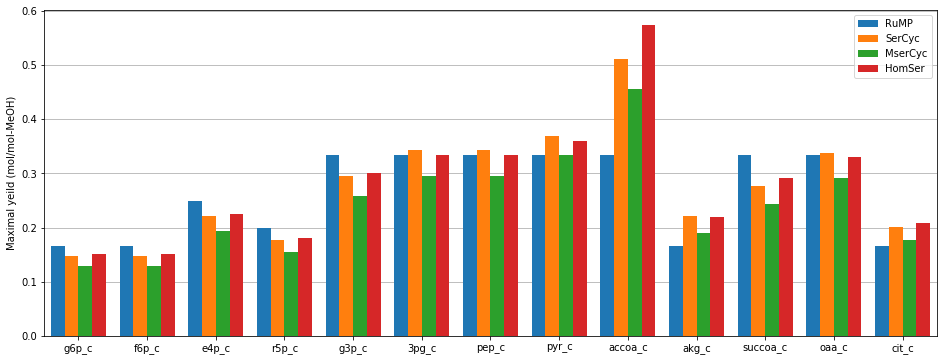

In [15]:
x = np.arange(len(precursors))
witdh = 0.2

fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xticks(x)
ax.set_xlim(-0.5, 12.5)
ax.set_xticklabels(precursors)
ax.set_yticklabels(map(str, np.arange(0, 7, 1)/10))
ax.set_ylabel('Maximal yeild (mol/mol-MeOH)')
plt.grid(which='both', axis='y')
ax.bar(x-1.5*witdh, precursors_results['RuMP'], witdh, label='RuMP')
ax.bar(x-0.5*witdh, precursors_results['SerCyc'], witdh, label = 'SerCyc')
ax.bar(x+0.5*witdh, precursors_results['MserCyc'], witdh, label = 'MserCyc')
ax.bar(x+1.5*witdh, precursors_results['HomSer'], witdh, label = 'HomSer')
plt.legend()
plt.savefig('13 precursors production figure.eps', dpi=300, bbox_inches='tight')
plt.show()

### Short summary
* The modified serine cycle has always the lowest yield.
* RuMP, serine cycle and homoserine cycle have their own advantage over others for certain products.
* When producing AcCoA and citrate, the homoserine cycle has the highest yield than the other pathways. 

### To produce some real chemicals. 


In [16]:
products = ['ac_e', 'etoh_e', 'acetone_e', 'but_e', 'buoh_e',
            'pyr_e', 'lac__D_e', 'ibtol_e', '23btdl_e',
            'cit_e', 'itacon_e', 'glu__L_e', 'asp__L_e', 'succ_e',
            'adpac_e', 'levu_e']


## Add new reactions for those pathways do not exist natively
* acetone: DOI: 10.1016/j.ymben.2012.08.001 
* butyrate: but_e; DOI: 10.1002/bit.24925
* 1-butanol: buoh_e; DOI: 10.1186/1475-2859-7-36
* isobutanol: ibtol_e; DOI: 10.1007/s00253-009-2085-6
* 2,3-butanediol: 23btdl_e; DOI: 10.1021/acssynbio.5b00057
* itaconate: itacon_e; DOI: 10.1007/s10529-017-2500-5
* adipic acid: adpac_e; DOI: 10.1002/bit.25293
* levulinic acid: levu_e; DOI: 10.1038/nbt.3505


In [17]:
model = AddRxn(model, 'NewRxn4Production.csv')

unknown metabolite '2mbald_c' created
unknown metabolite 'ibtol_c' created
unknown metabolite 'actn__R_c' created
unknown metabolite '23btdl_c' created
unknown metabolite 'acetone_c' created
unknown metabolite 'buoh_c' created
unknown metabolite 'itacon_c' created
unknown metabolite 'adpcoa_c' created
unknown metabolite 'adpp_c' created
unknown metabolite 'adpac_c' created
unknown metabolite 'levu_c' created


In [18]:
# saveif = True
saveif = False
prod_results = pd.DataFrame()

for psw, pswrxns in psws.items():
    with model:
        model = AddRxn(model, pswrxns)
        # print('Pathway %s' % psw)
        if psw == 'RuMP':
            AddKO = ['FTHFLi', 'THRA', 'THRD',]
        elif psw == 'HomSer':
            AddKO = ['FTHFLi', ]
        elif psw == 'SerCyc':
            AddKO = ['THRA', 'THRD', 'EtMaCoA']  # no EtMaCoA to be fair
        elif psw == 'MserCyc':
            AddKO = ['THRA', 'THRD',]
        KORxn(model, AddKO)
        for product in products:
            with model:
                # print('Product: %s' % product)
                change_objective(model, product)
                sol = prodFBA(model, psw, product, saveif)
                prod_results.loc[product, psw] = sol


unknown metabolite 'h6p_c' created
unknown metabolite 'malylcoa_c' created
unknown metabolite 'malylcoa_c' created
unknown metabolite 'hob_c' created


In [19]:
prod_results

,RuMP,SerCyc,MserCyc,HomSer
ac_e,3.333,5.676,5.000,6.140
etoh_e,3.333,3.818,3.500,4.490
acetone_e,1.667,2.692,2.386,2.966
but_e,1.667,2.283,2.059,2.652
buoh_e,1.667,1.909,1.750,2.245
pyr_e,3.333,3.750,3.387,3.646
lac__D_e,3.333,3.333,3.043,3.398
ibtol_e,1.667,1.628,1.489,1.675
23btdl_e,1.667,1.736,1.579,1.741
cit_e,1.667,2.000,1.750,2.071


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


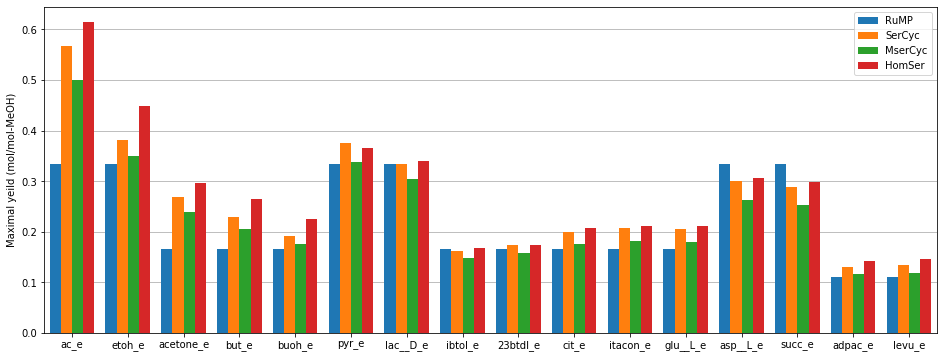

In [20]:
x = np.arange(len(products))
witdh = 0.2

fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xticks(x)
ax.set_xlim(-0.5, 15.5)
ax.set_xticklabels(products)
ax.set_yticklabels(map(str, np.arange(0, 7, 1)/10))
ax.set_ylabel('Maximal yeild (mol/mol-MeOH)')
plt.grid(which='both', axis='y')
ax.bar(x-1.5*witdh, prod_results['RuMP'], witdh, label='RuMP')
ax.bar(x-0.5*witdh, prod_results['SerCyc'], witdh, label = 'SerCyc')
ax.bar(x+0.5*witdh, prod_results['MserCyc'], witdh, label = 'MserCyc')
ax.bar(x+1.5*witdh, prod_results['HomSer'], witdh, label = 'HomSer')
plt.legend()
plt.savefig('chemical production from formladehyde figure.eps', dpi=300, bbox_inches='tight')
plt.show()


In [21]:
# add NADH oxidation reaction to check overflow reducing power
rxn = cobra.Reaction(id="NADHOx", name="NADH oxidation", lower_bound=0, upper_bound=1000)
model.add_reaction(rxn)
rxn.add_metabolites({"nadh_c": -1, "o2_c": -0.5, "h_c": -1, "nad_c": 1, "h2o_c": 1})

In [22]:
prod_results2 = pd.DataFrame()
dissipation = pd.DataFrame()

for psw, pswrxns in psws.items():
    with model:
        model = AddRxn(model, pswrxns)
        # print('Pathway %s' % psw)
        if psw == 'RuMP':
            AddKO = ['FTHFLi', 'THRA', 'THRD',]
        elif psw == 'HomSer':
            AddKO = ['FTHFLi', ]
        elif psw == 'SerCyc':
            AddKO = ['THRA', 'THRD', 'EtMaCoA']  # no EtMaCoA to be fair
        elif psw == 'MserCyc':
            AddKO = ['THRA', 'THRD',]
        KORxn(model, AddKO)
        for product in products:
            with model:
                # print('Product: %s' % product)
                change_objective(model, product)
                # sol = prodFBA(model, psw, product, False)
                sol = model.optimize().objective_value
                prod_results2.loc[product, psw] = round(sol,3)
                flux2file(model, f"01_{product}_dis", psw, False)

                model.reactions.get_by_id(f"EX_{product}").bounds = (sol, sol)
                model.objective = 'NADHOx'
                sol2 = model.optimize()
                dissipation.loc[product, psw] = round(sol2.objective_value, 3)
                flux2file(model, f"02_{product}_dis", psw, False)

unknown metabolite 'h6p_c' created
unknown metabolite 'malylcoa_c' created
unknown metabolite 'malylcoa_c' created
unknown metabolite 'hob_c' created


In [23]:
prod_results2

,RuMP,SerCyc,MserCyc,HomSer
ac_e,3.333,5.676,5.000,6.140
etoh_e,3.333,3.818,3.500,4.490
acetone_e,1.667,2.692,2.386,2.966
but_e,1.667,2.283,2.059,2.652
buoh_e,1.667,1.909,1.750,2.245
pyr_e,3.333,3.750,3.387,3.646
lac__D_e,3.333,3.333,3.043,3.398
ibtol_e,1.667,1.628,1.489,1.675
23btdl_e,1.667,1.736,1.579,1.741
cit_e,1.667,2.000,1.750,2.071


In [24]:
dissipation

,RuMP,SerCyc,MserCyc,HomSer
ac_e,16.667,-0.0,-0.0,0.0
etoh_e,10.000,0.0,0.0,0.0
acetone_e,16.667,0.0,-0.0,0.0
but_e,13.333,-0.0,-0.0,0.0
buoh_e,10.000,0.0,0.0,0.0
pyr_e,13.333,-0.0,0.0,0.0
lac__D_e,10.000,-0.0,0.0,-0.0
ibtol_e,10.000,-0.0,0.0,0.0
23btdl_e,11.667,0.0,0.0,0.0
cit_e,15.000,-0.0,-0.0,0.0


* RuMP has overflow of electrons. 
* The homoserine cycle uses PPC fixing CO2 to be a sink for electrons (reducing power).

In [25]:
yield2plot = pd.concat([precursors_results.loc[['g6p_c', 'r5p_c','g3p_c','3pg_c'],['RuMP','SerCyc','HomSer']],
                        prod_results.loc[['pyr_e','lac__D_e','ibtol_e','23btdl_e'],['RuMP','SerCyc','HomSer']],
                        precursors_results.loc[['accoa_c'],['RuMP','SerCyc','HomSer']],
                        prod_results.loc[['etoh_e','acetone_e','but_e','buoh_e','cit_e','itacon_e'],['RuMP','SerCyc','HomSer']],
                        precursors_results.loc[['akg_c'],['RuMP','SerCyc','HomSer']],
                        prod_results.loc[['succ_e','levu_e'],['RuMP','SerCyc','HomSer']]
])
yield2plot

,RuMP,SerCyc,HomSer
g6p_c,1.667,1.479,1.505
r5p_c,2.000,1.775,1.806
g3p_c,3.333,2.958,3.010
3pg_c,3.333,3.443,3.333
pyr_e,3.333,3.750,3.646
lac__D_e,3.333,3.333,3.398
ibtol_e,1.667,1.628,1.675
23btdl_e,1.667,1.736,1.741
accoa_c,3.333,5.122,5.738
etoh_e,3.333,3.818,4.490


In [27]:
# yield of RuMP as 100%
yield_norm = yield2plot.div(yield2plot.RuMP, axis=0) * 100
round(yield_norm,1)

,RuMP,SerCyc,HomSer
g6p_c,100.0,88.7,90.3
r5p_c,100.0,88.8,90.3
g3p_c,100.0,88.7,90.3
3pg_c,100.0,103.3,100.0
pyr_e,100.0,112.5,109.4
lac__D_e,100.0,100.0,102.0
ibtol_e,100.0,97.7,100.5
23btdl_e,100.0,104.1,104.4
accoa_c,100.0,153.7,172.2
etoh_e,100.0,114.6,134.7


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


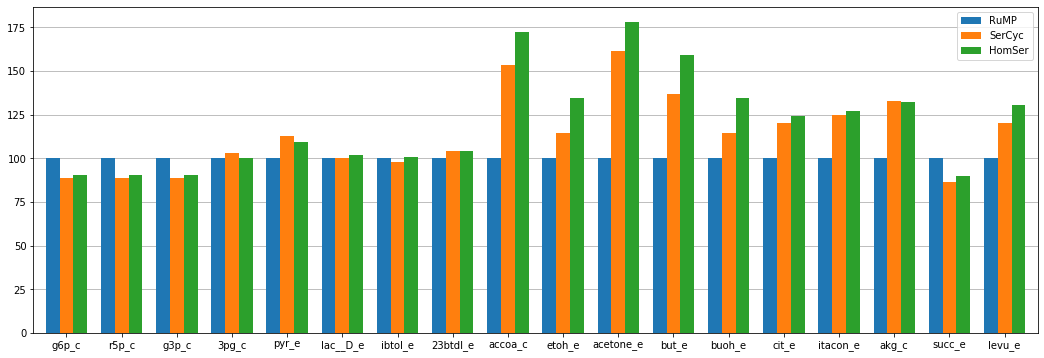

In [28]:
x = np.arange(len(yield_norm))
witdh = 0.25

fig, ax = plt.subplots(figsize=(18, 6))
ax.set_xticks(x)
ax.set_xlim(-0.6, 17.6)
ax.set_xticklabels(yield_norm.index.to_numpy())
# ax.set_ylim(0, 185)
ax.set_ylabel('')
plt.grid(which='both', axis='y')
ax.bar(x-1*witdh, yield_norm['RuMP'], witdh, label='RuMP')
ax.bar(x, yield_norm['SerCyc'], witdh, label = 'SerCyc')
ax.bar(x+1*witdh, yield_norm['HomSer'], witdh, label = 'HomSer')
plt.legend()
plt.savefig('chemical production comparison figure.eps', dpi=300, bbox_inches='tight')
plt.show()